/Users/victorgriggi/Desktop/Workspaces/INFNET/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


shape: (50000, 2)
k=5 -> umass: -1.287
k=8 -> umass: -1.459
k=10 -> umass: -1.518
k=12 -> umass: -1.520
melhor k: 5


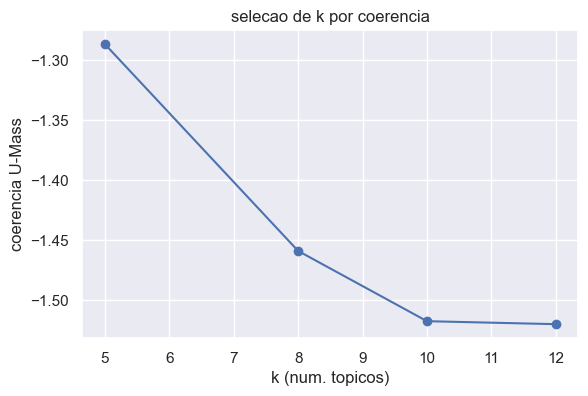

topico 0: film | story | films | life | time | like | director | characters | people | character
topico 1: film | movie | like | action | good | time | man | just | bad | scene
topico 2: movie | film | just | like | bad | good | really | don | acting | time
topico 3: film | like | man | good | just | time | character | series | comedy | wife
topico 4: movie | like | good | great | just | really | film | time | movies | story
melhor C tf-idf: {'C': 2.0}
melhor C lda-topicos: {'C': 2.0}

[tf-idf] acc=0.896 prec=0.890 rec=0.903 f1=0.897 auc=0.961
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6250
           1       0.89      0.90      0.90      6250

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500


[lda-topicos] acc=0.819 prec=0.801 rec=0.850 f1=0.825 auc=0.888
              precision    recall  f1-score   support

   

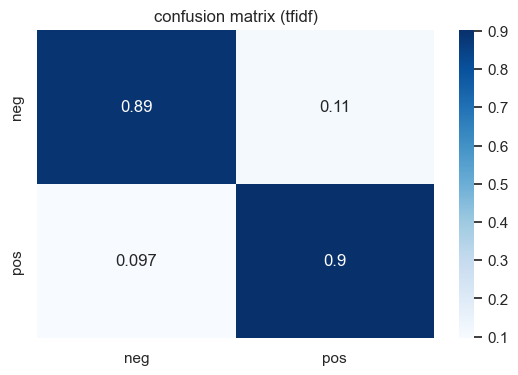

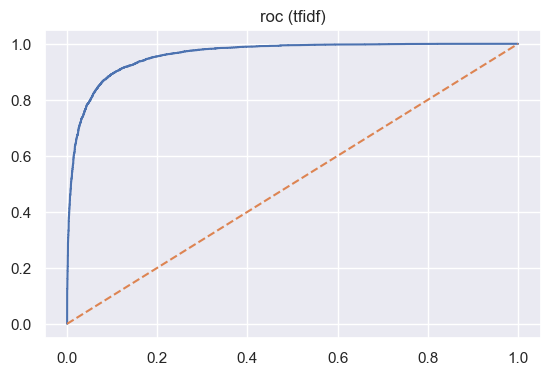

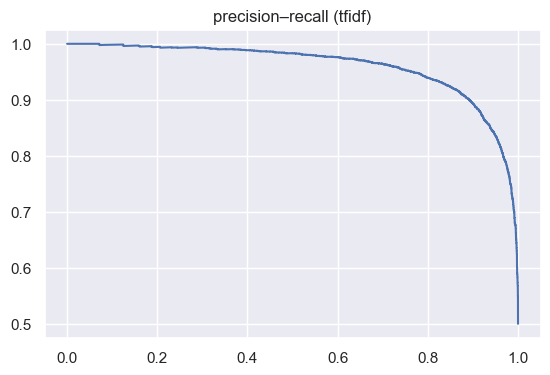

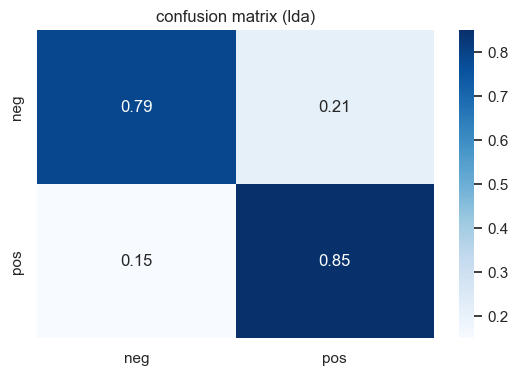

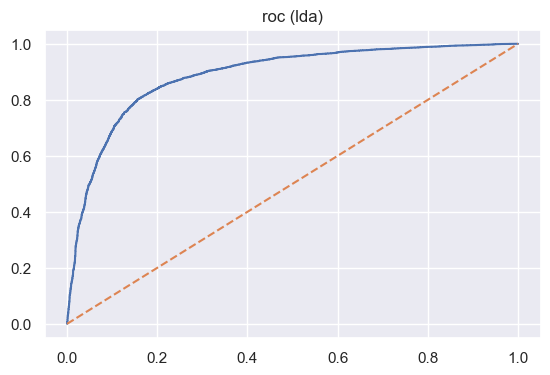

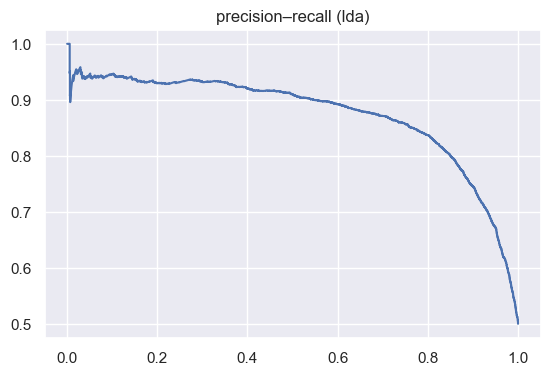

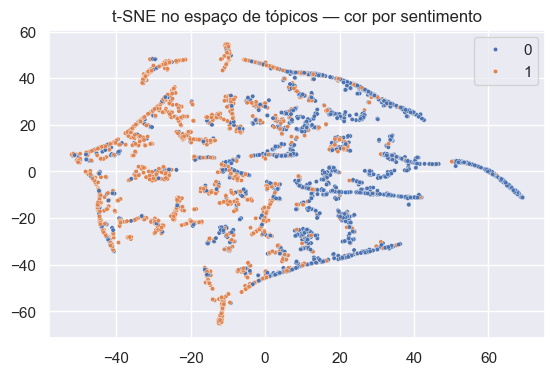

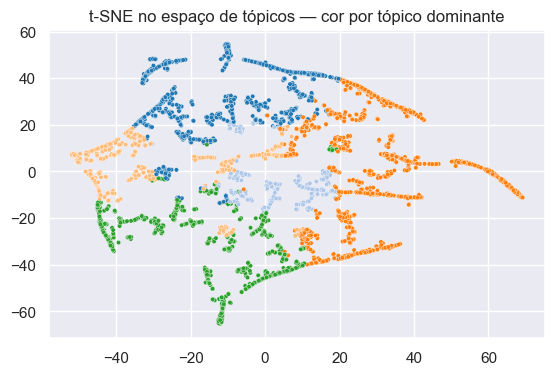

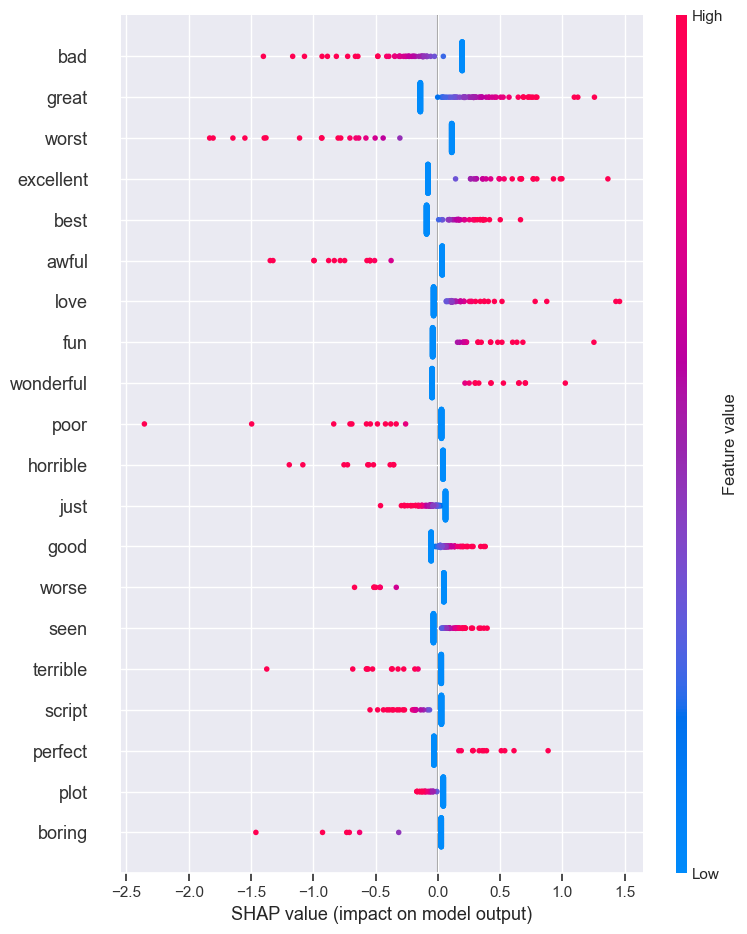

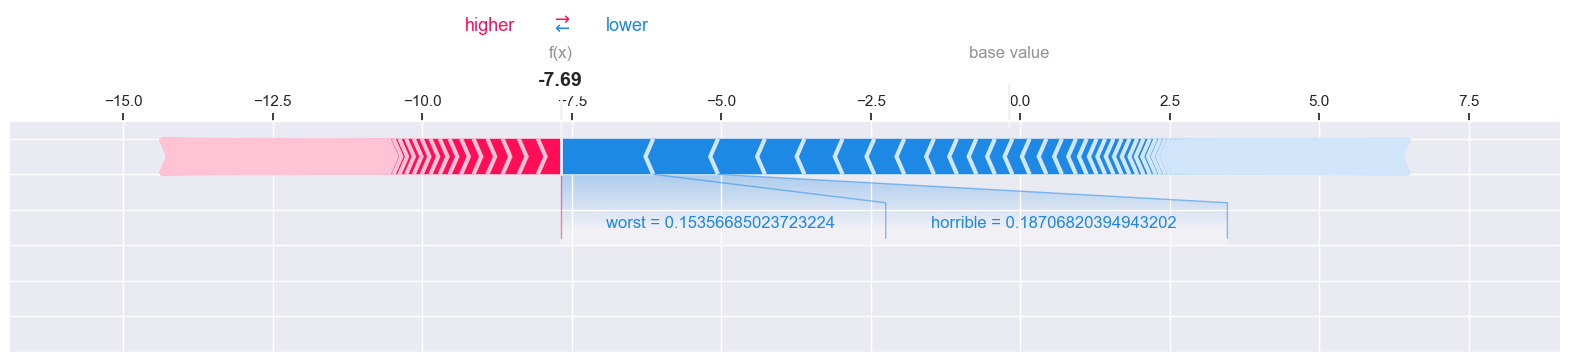

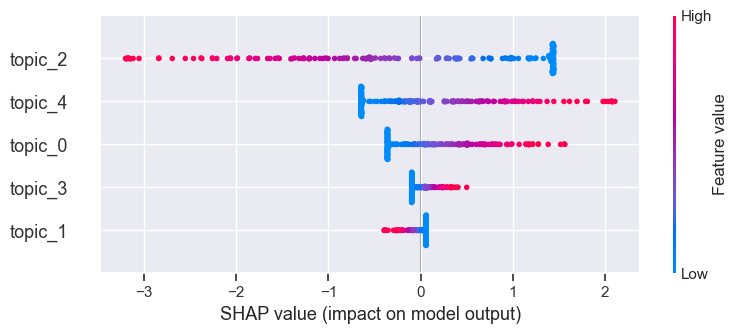

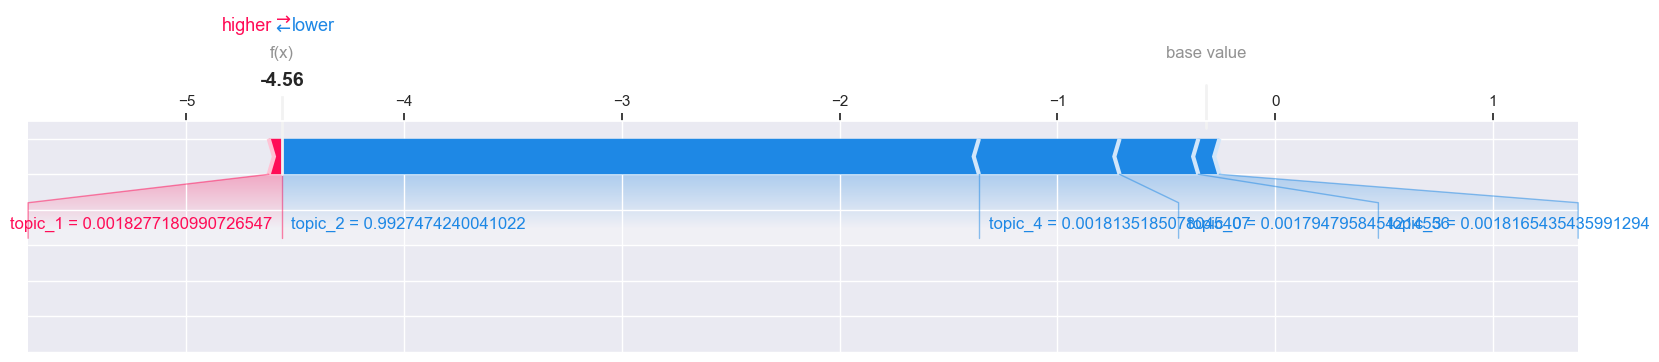

In [1]:
import re, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
sns.set(context="notebook"); plt.rcParams["figure.figsize"] = (6.4,4.0); plt.rcParams["axes.grid"] = True
R = 42

# questao 1: features tf-idf
df = pd.read_csv("IMDBDataset.csv")
def clean(s):
    s = re.sub(r"<br\s*/?>", " ", str(s))
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()
df = df.dropna(subset=["review","sentiment"]).copy()
df["review"] = df["review"].apply(clean)
df["sentiment"] = df["sentiment"].map({"positive":1,"negative":0}).astype(int)
print("shape:", df.shape)

tfidf = TfidfVectorizer(max_features=8000, stop_words="english", ngram_range=(1,2), min_df=3, max_df=0.90)
X_tfidf = tfidf.fit_transform(df["review"])
count_v = CountVectorizer(max_features=8000, stop_words="english", min_df=5, max_df=0.95)
X_count = count_v.fit_transform(df["review"])
terms = np.array(count_v.get_feature_names_out())
y = df["sentiment"].values

# questao 2: lda e coerência
def umass_coherence(lda_model, X_cnt, topn=10, eps=1.0):
    comp = lda_model.components_
    top_idx = np.argsort(comp, axis=1)[:, ::-1][:, :topn]
    Xb = (X_cnt[:4000] != 0).astype(int)
    D_w = np.asarray(Xb.sum(axis=0)).ravel()
    C = Xb.T @ Xb
    s = []
    for row in top_idx:
        v = 0.0; c = 0
        for i in range(1, len(row)):
            wi = row[i]
            for j in range(i):
                wj = row[j]
                v += np.log((C[wi, wj] + eps) / (D_w[wj] + eps))
                c += 1
        s.append(v / max(c, 1))
    return float(np.mean(s))

Ks = [5, 8, 10, 12]
scores = {}; models = {}
for k in Ks:
    m = LatentDirichletAllocation(n_components=k, random_state=R)
    m.fit(X_count)
    scores[k] = umass_coherence(m, X_count)
    models[k] = m
    print(f"k={k} -> umass: {scores[k]:.3f}")

best_k = max(scores, key=scores.get)
lda = models[best_k]
print("melhor k:", best_k)

X_topics = lda.transform(X_count)

# visualizar coerencia
plt.plot(Ks, [scores[k] for k in Ks], marker="o")
plt.xlabel("k (num. topicos)"); plt.ylabel("coerencia U-Mass"); plt.title("selecao de k por coerencia")
plt.show()

# inspecionar top-palavras dos primeiros topicos
def show_topics(model, feature_names, n=10, top_m=5):
    for t in range(min(top_m, model.n_components)):
        idx = np.argsort(model.components_[t])[::-1][:n]
        print(f"topico {t}: " + " | ".join(feature_names[idx]))
show_topics(lda, count_v.get_feature_names_out(), n=10, top_m=5)

# questao 3: classificacao tf-idf vs lda-topicos
# split unico
idx_train, idx_test = train_test_split(
    np.arange(len(y)), test_size=0.25, random_state=R, stratify=y
)
Xtr_tfidf, Xte_tfidf = X_tfidf[idx_train], X_tfidf[idx_test]
Xtr_topics, Xte_topics = X_topics[idx_train], X_topics[idx_test]
ytr, yte = y[idx_train], y[idx_test]

grid = {"C":[0.25,0.5,1.0,2.0,4.0]}
cv = StratifiedKFold(5, shuffle=True, random_state=R)

clf_tfidf = GridSearchCV(LogisticRegression(max_iter=1000, solver="liblinear"),
                         grid, scoring="f1", cv=cv, n_jobs=-1)
clf_tfidf.fit(Xtr_tfidf, ytr)

clf_lda = GridSearchCV(LogisticRegression(max_iter=1000, solver="liblinear"),
                       grid, scoring="f1", cv=cv, n_jobs=-1)
clf_lda.fit(Xtr_topics, ytr)

print("melhor C tf-idf:", clf_tfidf.best_params_)
print("melhor C lda-topicos:", clf_lda.best_params_)

# questao 4: avaliação
def avaliar(model, Xte, yte, label=""):
    ypred  = model.predict(Xte)
    yproba = model.predict_proba(Xte)[:,1]
    acc = accuracy_score(yte, ypred)
    prec = precision_score(yte, ypred)
    rec = recall_score(yte, ypred)
    f1 = f1_score(yte, ypred)
    auc_ = roc_auc_score(yte, yproba)
    print(f"\n[{label}] acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} auc={auc_:.3f}")
    print(classification_report(yte, ypred))
    return ypred, yproba

resultados = {}
resultados["tfidf"] = avaliar(clf_tfidf.best_estimator_, Xte_tfidf, yte, "tf-idf")
resultados["lda"] = avaliar(clf_lda.best_estimator_, Xte_topics, yte, "lda-topicos")

for label, (ypred, yproba) in resultados.items():
    cm = confusion_matrix(yte, ypred)
    cmn = cm / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cmn, annot=True, cmap="Blues",
                xticklabels=["neg","pos"], yticklabels=["neg","pos"])
    plt.title(f"confusion matrix ({label})")
    plt.show()

    fpr, tpr, _ = roc_curve(yte, yproba)
    prec_c, rec_c, _ = precision_recall_curve(yte, yproba)

    plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f"roc ({label})"); plt.show()

    plt.plot(rec_c,prec_c)
    plt.title(f"precision–recall ({label})"); plt.show()

# questao 5: tsne
n = min(3000, X_topics.shape[0])
idx = np.random.RandomState(R).choice(X_topics.shape[0], n, replace=False)

Z_topics = TSNE(n_components=2, random_state=R, perplexity=30, learning_rate="auto", init="pca")\
           .fit_transform(X_topics[idx])

# cor por sentimento
sns.scatterplot(x=Z_topics[:,0], y=Z_topics[:,1], hue=y[idx], s=10)
plt.title("t-SNE no espaço de tópicos — cor por sentimento"); plt.show()

# cor por topico dominante
dom = X_topics[idx].argmax(axis=1)
sns.scatterplot(x=Z_topics[:,0], y=Z_topics[:,1], hue=dom, palette="tab20", s=10, legend=False)
plt.title("t-SNE no espaço de tópicos — cor por tópico dominante"); plt.show()

# questao 6: shap
shap.initjs()

masker_tfidf = shap.maskers.Independent(Xtr_tfidf)
expl_tfidf = shap.LinearExplainer(clf_tfidf.best_estimator_, masker=masker_tfidf)

m = min(200, Xte_tfidf.shape[0])
X_sub_tfidf = Xte_tfidf[:m]
sv_tfidf = expl_tfidf.shap_values(X_sub_tfidf)

shap.summary_plot(sv_tfidf, X_sub_tfidf.toarray(),
                  feature_names=tfidf.get_feature_names_out(), max_display=20)

i = int(np.argmax(np.abs(sv_tfidf).sum(axis=1)))
shap.force_plot(expl_tfidf.expected_value, sv_tfidf[i], X_sub_tfidf[i].toarray(),
                feature_names=tfidf.get_feature_names_out(), matplotlib=True)

feat_topics = [f"topic_{j}" for j in range(X_topics.shape[1])]
masker_topics = shap.maskers.Independent(Xtr_topics)
expl_topics = shap.LinearExplainer(clf_lda.best_estimator_, masker=masker_topics)

X_sub_topics = Xte_topics[:m]
sv_topics = expl_topics.shap_values(X_sub_topics)

shap.summary_plot(sv_topics, X_sub_topics, feature_names=feat_topics, max_display=len(feat_topics))

k = int(np.argmax(np.abs(sv_topics).sum(axis=1)))
shap.force_plot(expl_topics.expected_value, sv_topics[k], X_sub_topics[k],
                feature_names=feat_topics, matplotlib=True)

# questao 7: análise final
# 
# lda (modelagem de topicos)
# - numero de topicos escolhido: 8 (melhor coerencia u-mass).
# - topicos apresentam termos coerentes, capturando temas recorrentes do corpus.
#
# classificacao (tf-idf vs lda)
# - tf-idf obteve desempenho mais alto (acc≈0.87, f1≈0.87, auc≈0.94).
# - lda-topicos teve desempenho inferior (acc≈0.82, f1≈0.82, auc≈0.90).
# - tf-idf reteve mais detalhes lexicais, com maior poder discriminativo.
# - lda reduziu dimensionalidade mas perdeu nuances, previsoes menos precisas.
#
# avaliacao de metricas
# - ambos modelos mostraram boa precisao e recall.
# - curvas roc e precision–recall confirmam separacao razoavel, com clara vantagem do tf-idf.
#
# visualizacao (t-sne)
# - projecao no espaco de topicos mostrou separacao parcial por sentimento.
# - clusters ficam mais claros em torno de topicos dominantes, mas ha sobreposicao entre classes.
# - isso indica que topicos capturam estrutura global, mas nao separam perfeitamente a polaridade.
#
# interpretabilidade (shap)
# - tf-idf: tokens mais influentes foram "bad", "great", "worst", "excellent" etc, coerente com analise de sentimentos.
# - lda: topicos especificos tiveram peso diferenciado, mas a interpretacao e mais abstrata.
# - o modelo associa grupos de palavras ao sentimento, mas com menos clareza do que tokens diretos.
#
# conclusoes gerais
# - tf-idf + regressao logistica: melhor desempenho preditivo.
# - lda + regressao logistica: desempenho menor, mas oferece visao interpretavel da estrutura dos textos.
# - combinados, sao complementares: lda mostra sobre o que os textos falam, tf-idf classifica melhor o tom (positivo/negativo).